In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib


## Convenience functions

In [2]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss

In [3]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

In [4]:
def get_logL_2d(data,model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
    d0,d1=data
    Pss = Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn)
    logL = np.sum(np.log(Pss[d0,d1]))
    return logL

def Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
#     print(bp_is_bpn)
    if sr<1:
        pn = 1
        pm = sr
    else:
        pm = 1
        pn = 1/sr
    if bp_is_bpn:
        b = bp/pn
        beta = bp/m_N
        gamma = b*pm/m_M
    else:
        b = bp/pm
        gamma = bp/m_M
        beta = b*pn/m_N
    samp = [pn,pm]
    p = np.log10([b,beta,gamma])
    return model.get_Pss(p,mx,samp)

### Basic tests

In [5]:
b=10
beta = 1
gamma = 0.4
p = np.log10(np.asarray([b,beta,gamma]))
samp = [0.4,0.2]
mx = [30,50]
x = np.arange(mx[0])

In [6]:
burst_model = BurstModel('None')
Pss_noisefree = burst_model.get_Pss(np.log10(np.asarray([b,beta,gamma])),[100,100])
samples = np.asarray(sample_from_p(100000,Pss_noisefree))

In [7]:
samples[0,:] = np.random.binomial(samples[0,:],samp[0])
samples[1,:] = np.random.binomial(samples[1,:],samp[1])

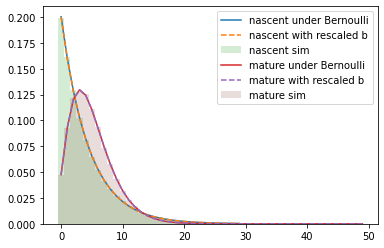

In [8]:
burst_model = BurstModel('Bernoulli')
Pss = burst_model.get_Pss(p,mx,samp)

plt.plot(Pss.sum(1),label='nascent under Bernoulli')
y = scipy.stats.nbinom.pmf(x,1/beta,1/(1+b*samp[0]))
plt.plot(x,y,'--',label='nascent with rescaled b')
bins = x-0.5
plt.hist(samples[0],bins,alpha=0.2,density=True,label='nascent sim')

burst_model = BurstModel('None')
Pss_ = burst_model.get_Pss(np.log10(np.asarray([b*samp[1],beta,gamma])),[1,50])
plt.plot(Pss.sum(0),label='mature under Bernoulli')
plt.plot(Pss_,'--',label='mature with rescaled b')
_=plt.hist(samples[1],bins,alpha=0.2,density=True,label='mature sim')

plt.legend()

# Parameter regimes

In [9]:
m_N = 7
bp = 4.9
m_M = 10
mx = [100,100]

In [10]:
burst_model = BurstModel('Bernoulli')
samp_ratios = [1/4,1,4] #pm/pn
n_trials = 200

sr_range = np.logspace(-2,2,200)
ncells_range = [20,50,100,200]
bp_is_bpn=True
color_coords = [0.1,0.3,0.5,0.9]
cmaps = ('Blues','Reds','Purples')
fs = 18
lw=3
dims = (8,5)


In [19]:
# logL_arr = np.zeros((len(samp_ratios),len(ncells_range),len(sr_range),n_trials))
# for k_,sr in enumerate(samp_ratios):
#     for j_,ncells in enumerate(ncells_range):
#         Pss_true = Pss_at_sr(burst_model,bp,m_N,m_M,sr,mx,bp_is_bpn=bp_is_bpn)
#         for trial in range(n_trials):
#             data = np.asarray(sample_from_p(ncells,Pss_true))
#             mx_ = data.max(1)+4
#             logL = np.asarray([get_logL_2d(data,burst_model,bp,m_N,m_M,sr_,mx_,bp_is_bpn=bp_is_bpn) for sr_ in sr_range])
#             logL -= scipy.special.logsumexp(logL)
#             logL_arr[k_,j_,:,trial]=logL


In [20]:
# import pickle
# with open('./data/gg230222_technoise_logL_2.pickle', "wb") as logLfs:
#     pickle.dump(logL_arr, logLfs)


In [21]:
import pickle
with open('./data/gg230222_technoise_logL_2.pickle', "rb") as logLfs:
    logL_arr = pickle.load(logLfs)


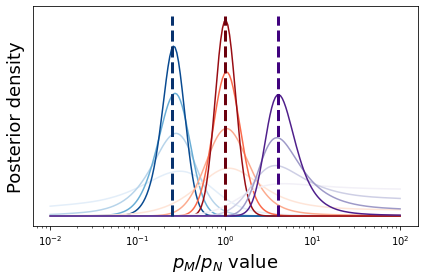

In [22]:
Larr = np.exp(logL_arr)
# plt.plot(sr_range,Larr.mean(1),c = matplotlib.colormaps[cmaps[k_]](color_coords[j_])[:3])
for k_,sr in enumerate(samp_ratios):
    for j_,ncells in enumerate(ncells_range):
        plt.plot(sr_range,Larr[k_,j_].mean(1),c = matplotlib.colormaps[cmaps[k_]](color_coords[j_])[:3])
plt.xscale('log')

for k_,sr in enumerate(samp_ratios):
    plt.plot([sr]*2,[0,0.07],'--',color=matplotlib.colormaps[cmaps[k_]](0.99)[:3],linewidth=lw)
plt.xlabel(r'$p_M/p_N$ value',fontsize=fs)
plt.ylabel('Posterior density',fontsize=fs)
plt.yticks([])
plt.tight_layout()
plt.savefig('figs/fig5b.png',dpi=450)
plt.savefig('figs/fig5b.pdf')
